In [43]:
%load_ext autoreload
%autoreload 2
import mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
file_dir='para/'

In [ ]:
res = mcfost.run_one_file(file_dir+'solar.para', wavelengths=[1.0], move_to_subdir=False)

In [46]:
model = mcfost.ModelResults(file_dir)
print(model)
print(list(model._wavelengths_lookup.values()))
model.describe()

mcfost    : WARNING  Multiple par files found... returning first: /home/u13/yuchialin/PlayMcfost/solar/para/solar.para


<MCFOST ModelResults in directory '/home/u13/yuchialin/PlayMcfost/solar/para'>
['1.0']
Model results in /home/u13/yuchialin/PlayMcfost/solar/para for solar.para
    Model has 1 inclinations from 0.0 to 0.0
    SED computed from 0.1 - 3000.0 microns using 150 wavelengths
    Images computed for 1 wavelengths: [1.] micron


In [47]:
inc=model.images['1.0']

In [48]:
px=512
py=512
psf_scale=1e-6/2.4*206264.806*32/512 ##arcsecs/pixel
xpix=(np.arange (-px/2, px/2, 1))*psf_scale
ypix=(np.arange (-px/2, px/2, 1))*psf_scale
sq_as_per_pix=psf_scale**2
c=2.99792*10**14
wave_length=1.0 #in microns#
jy=10**26

In [49]:
sst=np.reshape(inc.data[5,0],(px,py))
sst_jy=(sst/c)*(wave_length**2)*jy
np.max(sst_jy)

0.000970125369078262

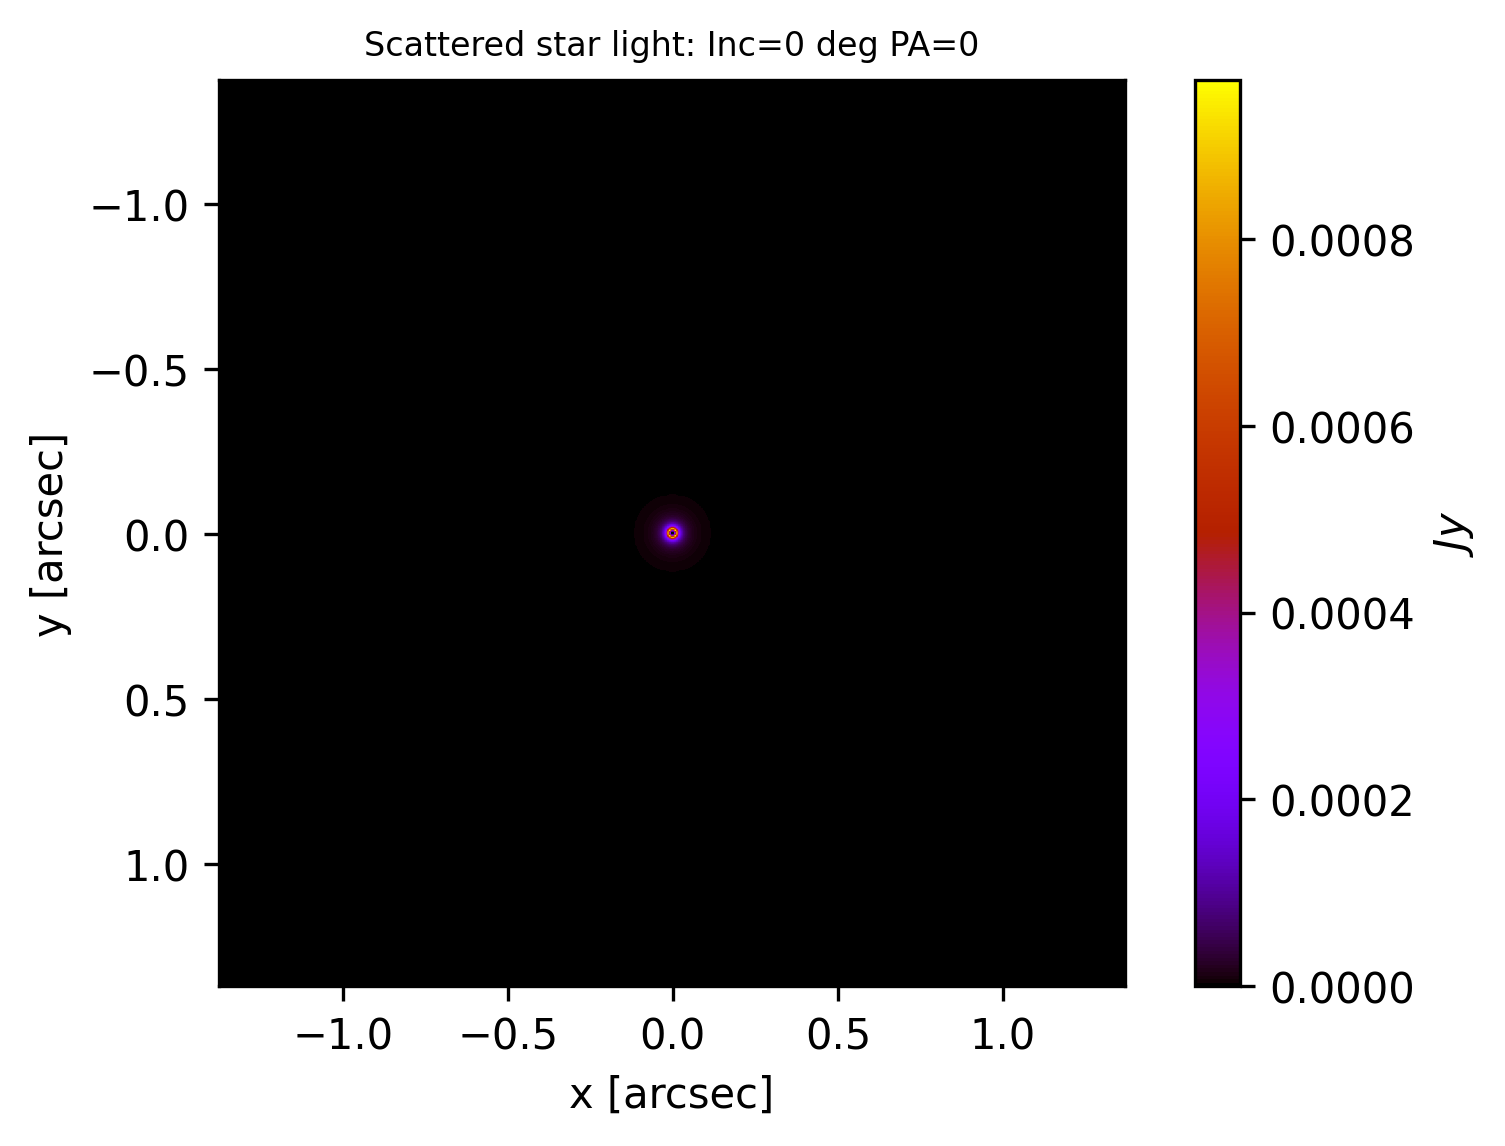

In [50]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(sst_jy.astype(np.float64),
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [38]:
!set NUMEXPR_MAX_THREADS = 64
from hcipy import *
#import numpy as np
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#mpl.rcParams['figure.dpi'] = 100

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

charge = 6
pupil_grid = make_pupil_grid(1024, 1.5)
focal_grid = make_focal_grid(16, 16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = evaluate_supersampled(make_circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(make_circular_aperture(0.5), pupil_grid, 4)
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

In [94]:
import numpy as np
import multiprocessing as mp
!set NUMEXPR_MAX_THREADS = 64
from hcipy import *
#import numpy as np
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#mpl.rcParams['figure.dpi'] = 100

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

charge = 10
pupil_grid = make_pupil_grid(1024, 1.5)
focal_grid = make_focal_grid(16, 16)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = evaluate_supersampled(make_circular_aperture(1), pupil_grid, 4)
lyot_mask = evaluate_supersampled(make_circular_aperture(0.5), pupil_grid, 4)
coro = VortexCoronagraph(pupil_grid, charge)
lyot_stop = Apodizer(lyot_mask)

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

def psf_chunk(i, img_pixel, psf_range):
    x = 2*i*psf_range / img_pixel
    wf = Wavefront(Wavefront_pos(x, 0))
    img = prop(lyot_stop(coro(wf))).intensity
    return i, img.to_dict()["values"].reshape(img_pixel, img_pixel)

def psf_calculation(img_pixel, psf_range):
    num_cores = 4
    chunk_size = img_pixel // (2*num_cores)
    psfs = np.empty((img_pixel//2+1, img_pixel, img_pixel))
    
    pool = mp.Pool(processes=num_cores)
    results = [pool.apply_async(psf_chunk, args=(i, img_pixel, psf_range)) for i in range(img_pixel//2+1)]
    pool.close()
    pool.join()
    for result in results:
        i, psf = result.get()
        psfs[i] = psf
    return psfs

img_pixel = 512
psf_range = 16
psfs = psf_calculation(img_pixel, psf_range)
np.save('psfs_c'+str(charge)+'.npy', psfs)

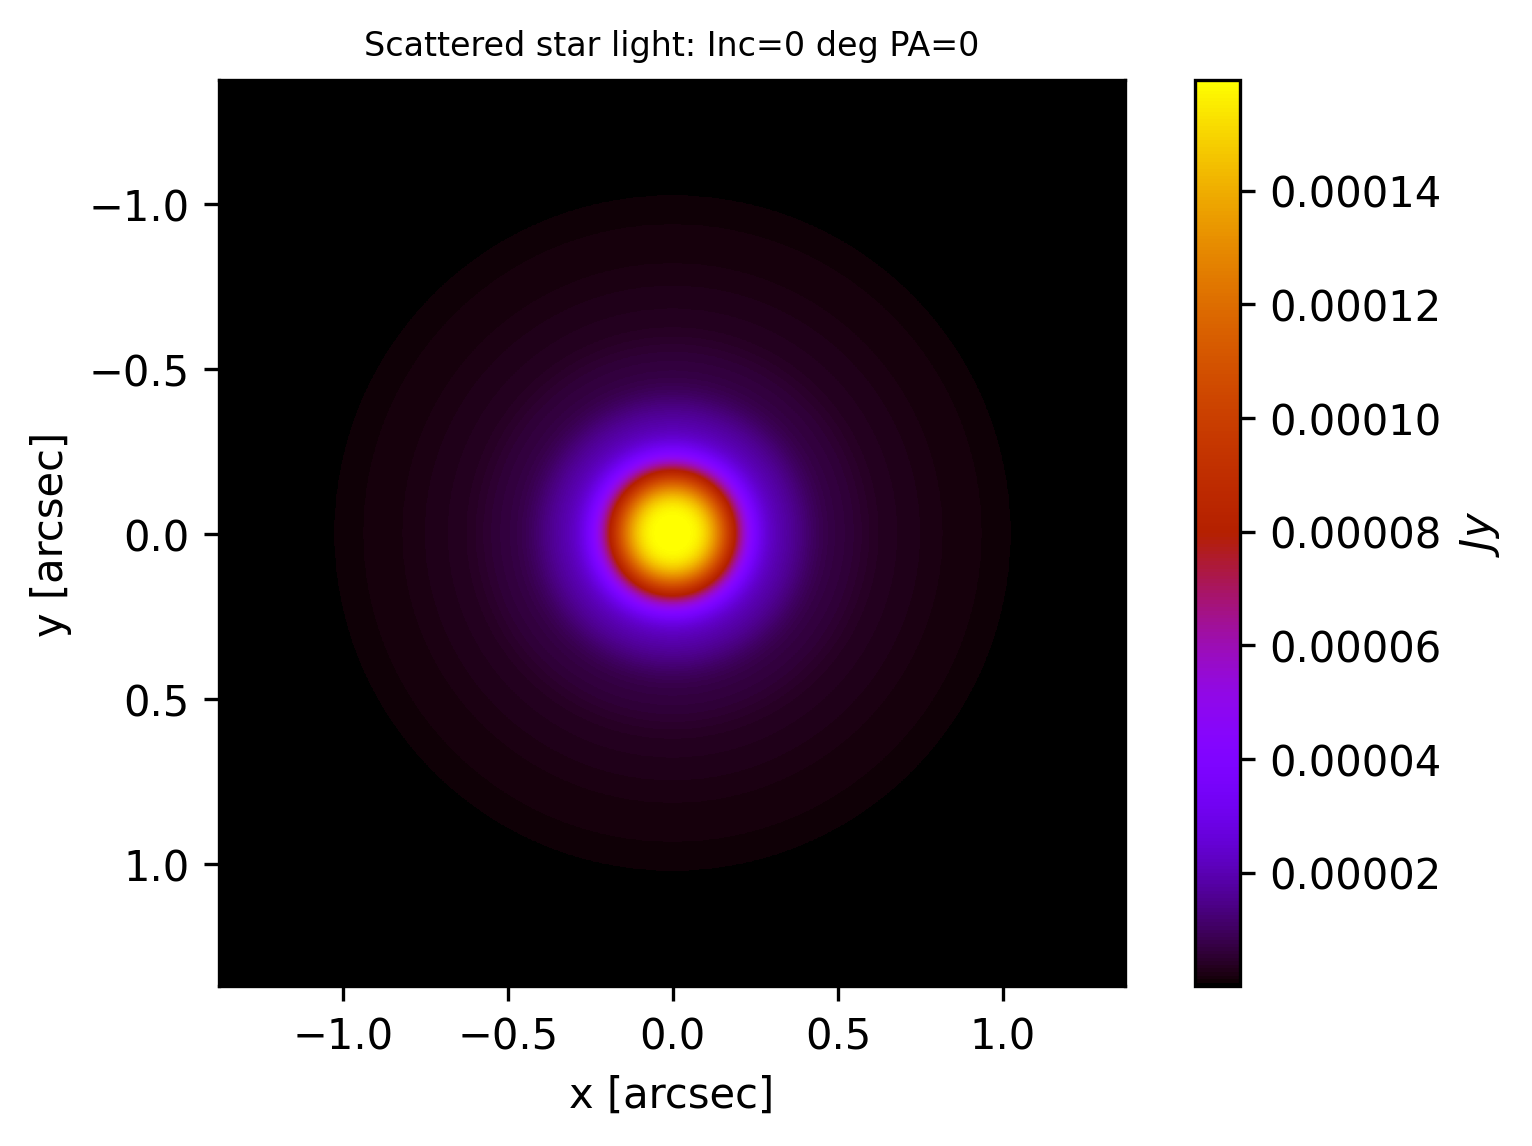

In [99]:
import numpy as np
import multiprocessing as mp
from skimage.transform import rotate

def cir_psf(pre_img, img_pixel, psf_range, rot_number, psfs_name=None):
    chunk_img = np.zeros([img_pixel, img_pixel])
    if psfs_name==None:
        for i in range(img_pixel//2+1):
            x = 2*i*psf_range / img_pixel
            weight = pre_img[255+i][255]
            if weight != 0:
                wf = Wavefront(Wavefront_pos(x, 0))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += 2*np.pi*i*weight*img.to_dict()["values"].reshape(img_pixel, img_pixel)/rot_number
    else:
        psfs = np.load(psfs_name)
        for i in range(img_pixel//2+1):
            weight = pre_img[255+i][255]
            if weight != 0:
                chunk_img += 2*np.pi*i*weight*psfs[i]/rot_number
    final_img = np.zeros([img_pixel, img_pixel])
    for i in range(rot_number):
        final_img += rotate(chunk_img, angle=360*i/rot_number)
    return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16
rot_number = 360


final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel, 'psfs_c2.npy')
#final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel)

#plot
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge6,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [64]:
import numpy as np
import multiprocessing as mp
from skimage.transform import rotate

def cir_psf(pre_img, img_pixel, psf_range, rot_number, psfs_name=None):
    chunk_img = np.zeros([img_pixel, img_pixel])
    if psfs_name==None:
        for i in range(img_pixel//2+1):
            x = 2*i*psf_range / img_pixel
            weight = pre_img[255+i][255]
            if weight != 0:
                wf = Wavefront(Wavefront_pos(x, 0))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += 2*np.pi*i*weight*img.to_dict()["values"].reshape(img_pixel, img_pixel)/rot_number
    else:
        psfs = np.load(psfs_name)
        for i in range(img_pixel//2+1):
            weight = pre_img[255+i][255]
            if weight != 0:
                chunk_img += 2*np.pi*i*weight*psfs[i]/rot_number
    final_img = np.zeros([img_pixel, img_pixel])
    for i in range(rot_number):
        final_img += rotate(chunk_img, angle=360*i/rot_number)
    return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16
rot_number = 360


#final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel, 'psfs_c6.npy')
final_img_charge6 = cir_psf(pre_img, img_pixel, psf_range, img_pixel)

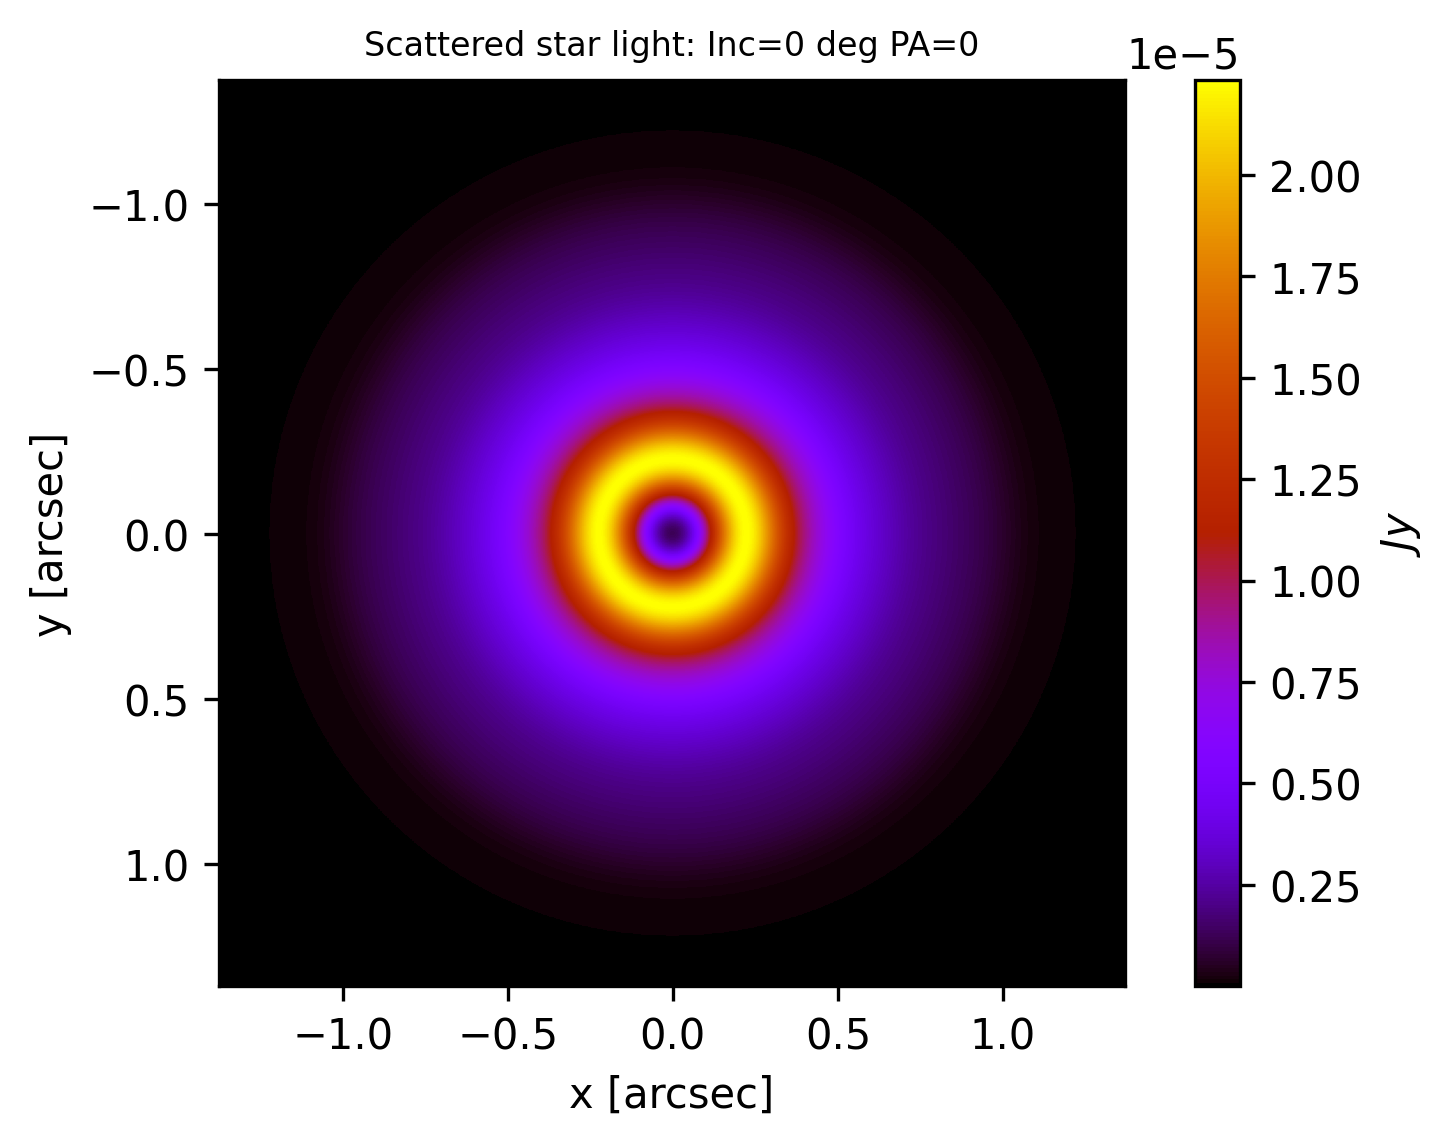

In [65]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge6,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [ ]:
import numpy as np
import multiprocessing as mp
'''
x>=y>=0
256>=x>=0

1.  x, y
2.  y ,x
3. -y, x
4. -x, y
5. -x,-y
6. -y,-x
7.  y,-x
8.  x,-y
'''

def Wavefront_pos(x,y):
    return aperture * np.exp(2j * np.pi * (pupil_grid.x * x + pupil_grid.y * y))

def psf_chunk(i, psfs, img_pixel, psf_range):
    print(i)
    x = 2*i*psf_range / img_pixel
    for j in range(i):
        y = 2*j*psf_range / img_pixel
        wf = Wavefront(Wavefront_pos(x, y))
        img = prop(lyot_stop(coro(wf))).intensity
        psf = img.to_dict()["values"].reshape(img_pixel, img_pixel)
        psfs[i][j] = psf
        psfs[j][i] = np.transpose(psf[::-1, ::-1])
    wf = Wavefront(Wavefront_pos(x, x))
    img = prop(lyot_stop(coro(wf))).intensity
    psfs[i][i] = img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return i

def psf_calculation(img_pixel, psf_range):
    psfs = np.empty((img_pixel//2 + 1, img_pixel//2 + 1, img_pixel, img_pixel))
    check_points = [psf_chunk(i, psfs, img_pixel, psf_range) for i in range(img_pixel//2 + 1)]
    np.save('psfs.npy', psfs)
    return 0

img_pixel = 512
psf_range = 16
psf_calculation(img_pixel, psf_range)

In [15]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    pool.close()
    pool.join()

    #
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

results = parallel_calculation(pre_img, img_pixel, psf_range)
chunk_results = [result.get() for result in results]
final_img_charge2 = np.sum(chunk_results, axis=0)

In [17]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    pool.close()
    pool.join()

    #
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

results = parallel_calculation(pre_img, img_pixel, psf_range)
chunk_results = [result.get() for result in results]
final_img_charge4 = np.sum(chunk_results, axis=0)

In [11]:
import numpy as np
import multiprocessing as mp

def calculate_chunk(chunk_range, pre_img, img_pixel, psf_range):
    chunk_img = np.zeros([img_pixel, img_pixel])
    for i in chunk_range:
        x = (2 * i + 2 - img_pixel) * psf_range / img_pixel
        for j in range(img_pixel):
            weight = pre_img[i][j]
            if weight != 0:
                y = (2 * j + 2 - img_pixel) * psf_range / img_pixel
                wf = Wavefront(Wavefront_pos(x, y))
                img = prop(lyot_stop(coro(wf))).intensity
                chunk_img += weight * img.to_dict()["values"].reshape(img_pixel, img_pixel)
    return chunk_img

def parallel_calculation(pre_img, img_pixel, psf_range):
    num_cores = 64
    chunk_size = img_pixel // num_cores

    pool = mp.Pool(processes=num_cores)
    chunk_ranges = [range(i * chunk_size, (i + 1) * chunk_size) for i in range(num_cores)]
    results = [pool.apply_async(calculate_chunk, args=(chunk_range, pre_img, img_pixel, psf_range)) for chunk_range in chunk_ranges]
    #chunk_results = [result.get() for result in results]
    pool.close()
    pool.join()

    #final_img = np.sum(chunk_results, axis=0)
    return results
    #return final_img

pre_img = sst_jy.astype(np.float64)
img_pixel = 512
psf_range = 16

final_img = parallel_calculation(pre_img, img_pixel, psf_range)
#print(final_img)

In [12]:
chunk_results = [result.get() for result in final_img[:]]
final_img_tmp = np.sum(chunk_results, axis=0)

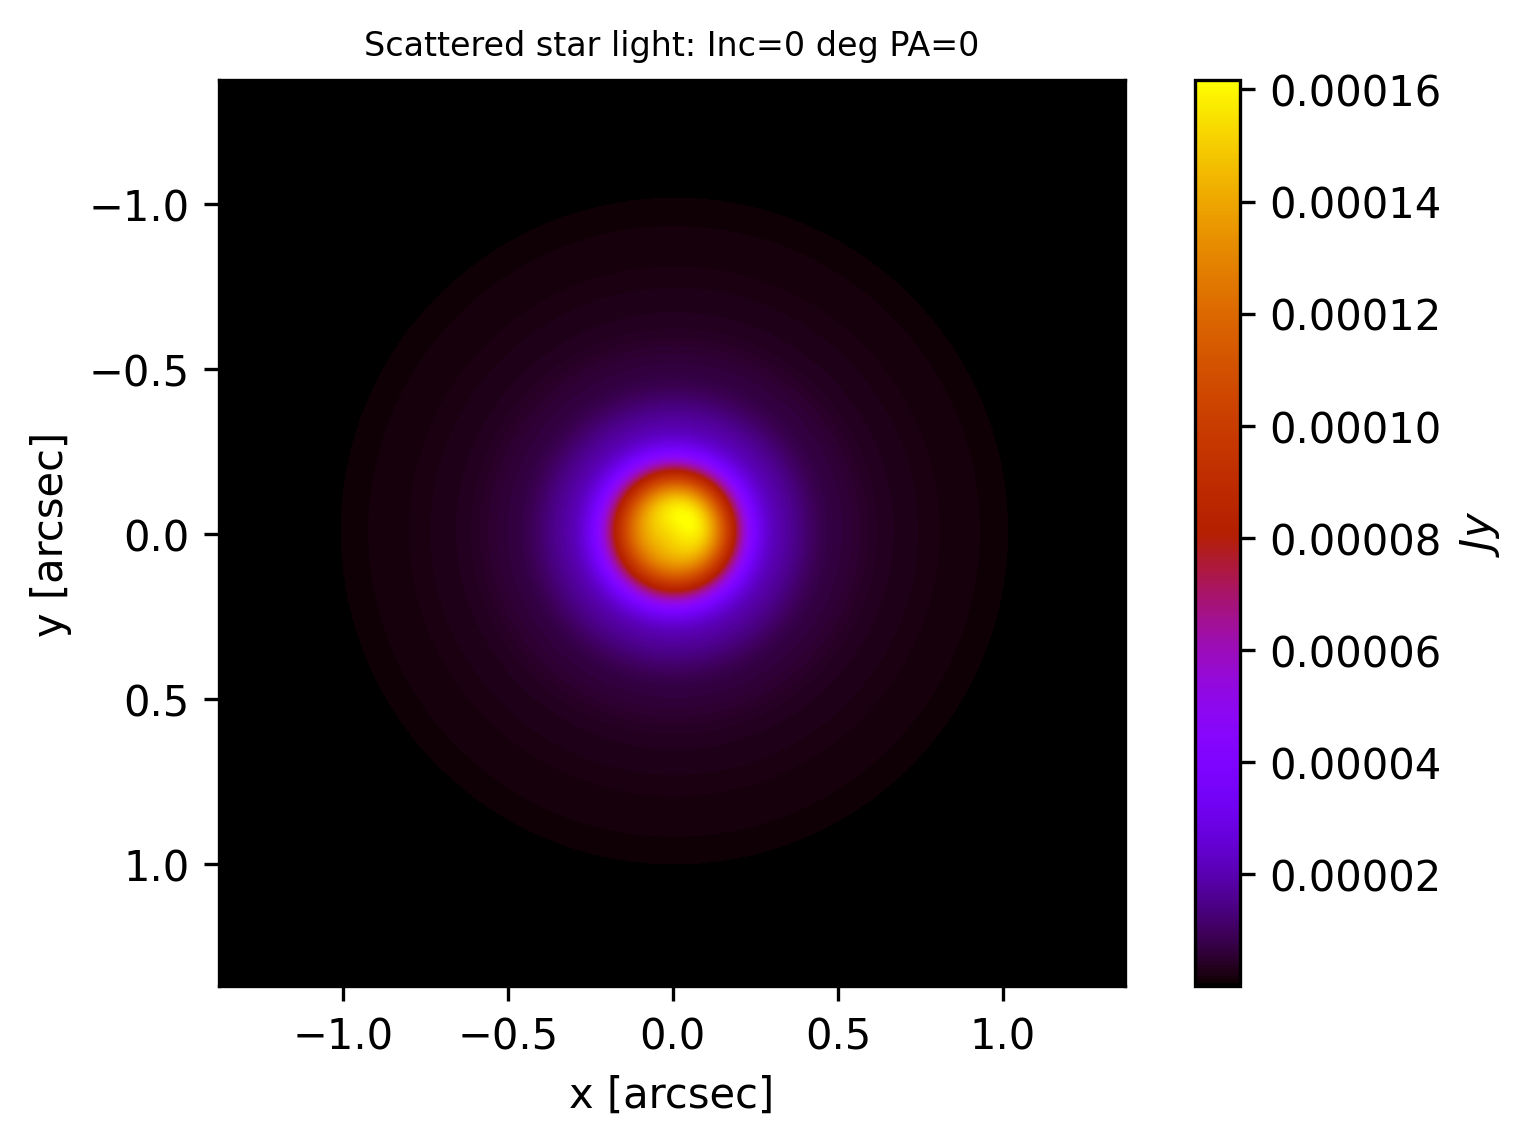

In [16]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge2,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

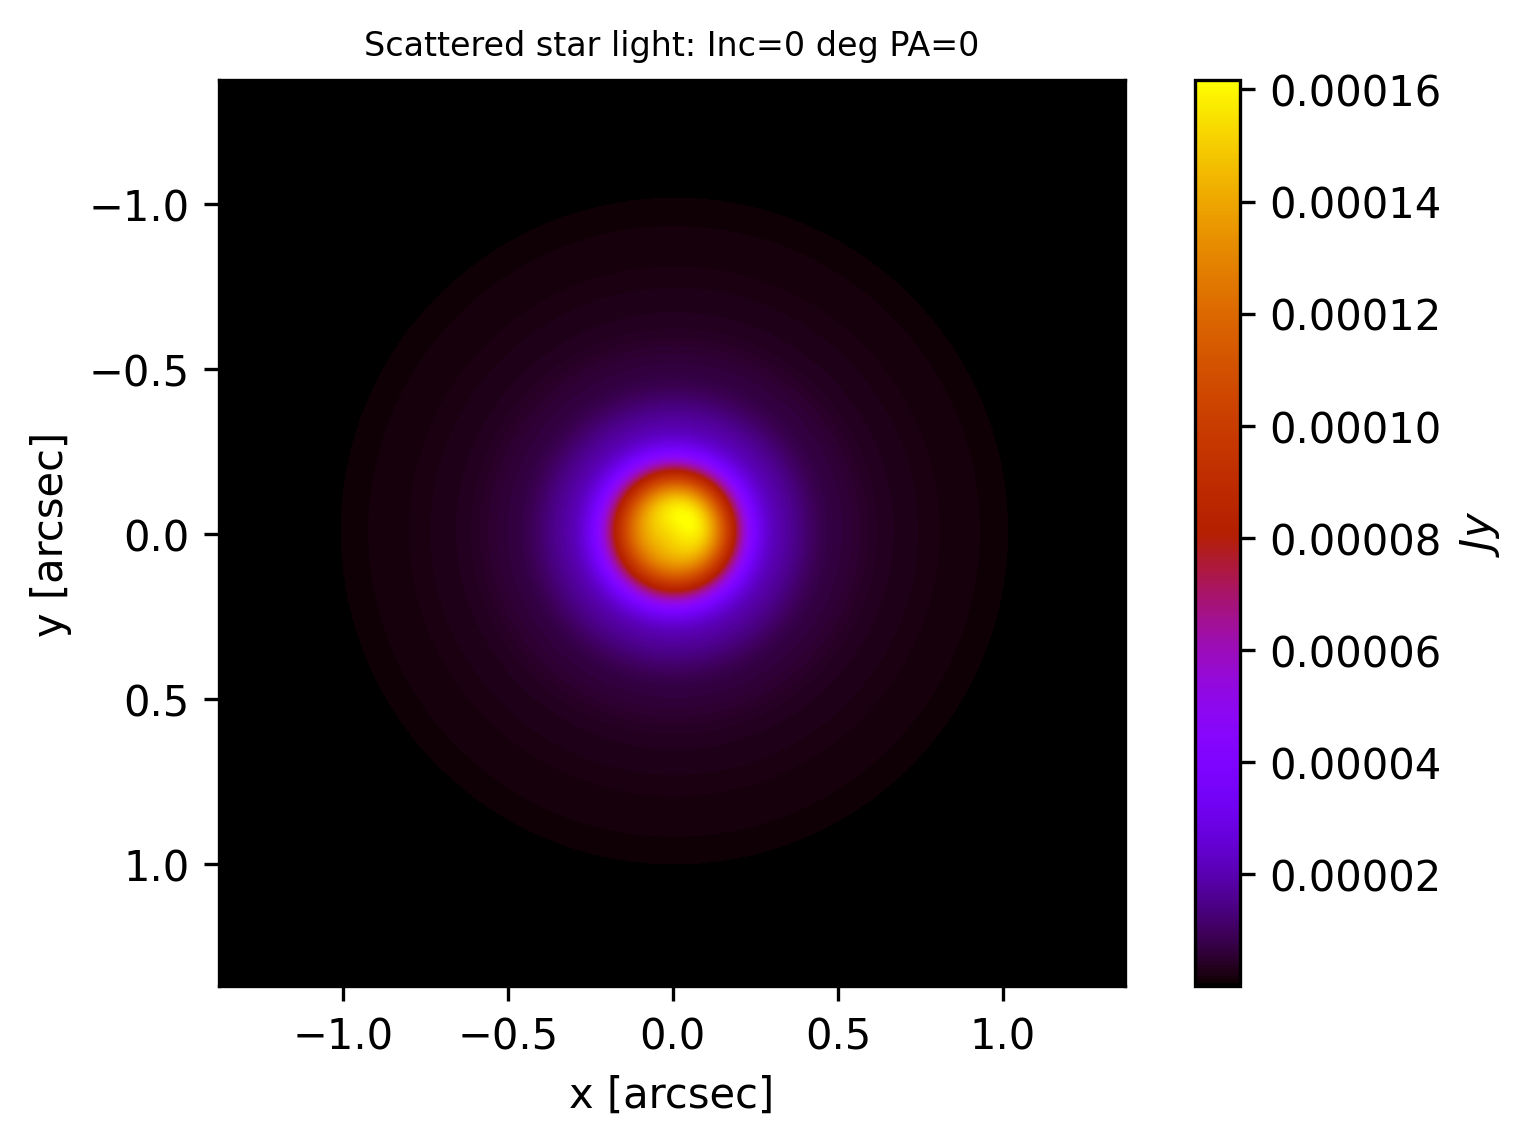

In [18]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_charge4,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

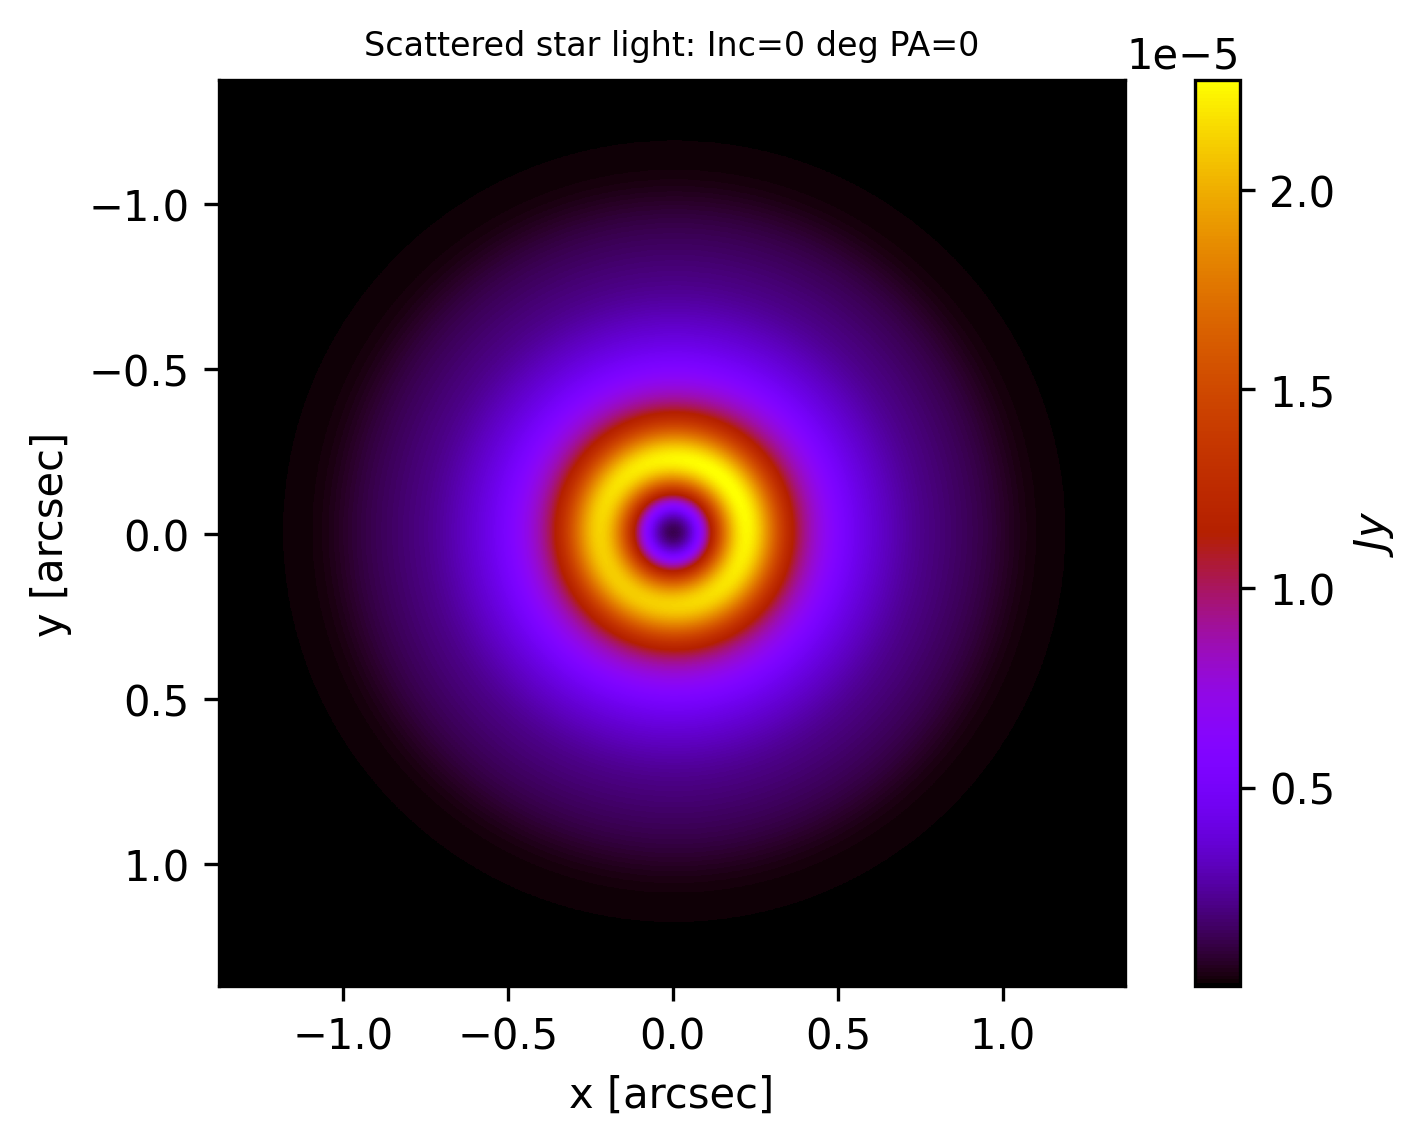

In [13]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(111)
im2=ax2.imshow(final_img_tmp,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered star light: Inc=0 deg PA=0',fontsize=8)
cb=plt.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
#fig.savefig(file_dir+'Su_model_575nm_inc0_pa266.pdf', format='pdf', bbox_inches='tight')

In [55]:
final_img_tmp

array([[7.95847615e-10, 7.99828221e-10, 8.04630270e-10, ...,
        8.18901137e-10, 8.13905757e-10, 8.09748913e-10],
       [8.00131088e-10, 8.05060462e-10, 8.10828977e-10, ...,
        8.25462842e-10, 8.19549095e-10, 8.14487040e-10],
       [8.05367284e-10, 8.11264956e-10, 8.18001366e-10, ...,
        8.32950255e-10, 8.26123597e-10, 8.20144875e-10],
       ...,
       [8.18177694e-10, 8.25261692e-10, 8.33186186e-10, ...,
        8.48831631e-10, 8.40821159e-10, 8.33657694e-10],
       [8.11742036e-10, 8.17839097e-10, 8.24798560e-10, ...,
        8.40151414e-10, 8.33039880e-10, 8.26799956e-10],
       [8.06291470e-10, 8.11399594e-10, 8.17373282e-10, ...,
        8.32373530e-10, 8.26188301e-10, 8.20882012e-10]])

In [64]:
#lambda/D in arcsec
#2.4m
#1000nm
1e-6/2.4*206264.806*16

1.3750987066666667

In [97]:
sst_jy.astype(np.float64)[511]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
#Polarization of the disk
I=np.reshape(inc.data[0,0],(px,py))
Q=np.reshape(inc.data[1,0],(px,py))
U=np.reshape(inc.data[2,0],(px,py))
V=np.reshape(inc.data[3,0],(px,py))
dst=np.reshape(inc.data[4,0],(px,py))
sst=np.reshape(inc.data[5,0],(px,py))
dth=np.reshape(inc.data[6,0],(px,py))
sth=np.reshape(inc.data[7,0],(px,py))

In [73]:
I_jy=(I/c)*(wave_length**2)*jy
Q_jy=(Q/c)*(wave_length**2)*jy
U_jy=(U/c)*(wave_length**2)*jy
V_jy=(V/c)*(wave_length**2)*jy
sst_jy=(sst/c)*(wave_length**2)*jy

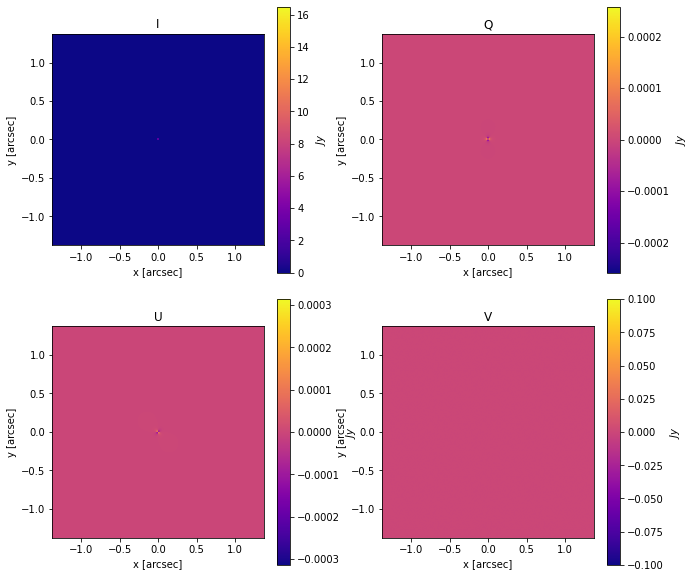

In [74]:
fig = plt.figure(figsize=(10, 10))
ax1=fig.add_subplot(221)
im1=ax1.imshow(I_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]')
ax1.set_title('I')
cb = fig.colorbar(im1,orientation='vertical')
cb.set_label("$Jy$")
ax1.grid(False)

ax2=fig.add_subplot(222)
im2=ax2.imshow(Q_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Q')
cb = fig.colorbar(im2,orientation='vertical')
cb.set_label("$Jy$")
ax2.grid(False)

ax3=fig.add_subplot(223)
im3=ax3.imshow(U_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax3.set_ylabel('y [arcsec]')
ax3.set_xlabel('x [arcsec]')
ax3.set_title('U')
cb = fig.colorbar(im3,orientation='vertical')
cb.set_label("$Jy$")
ax3.grid(False)

ax4=fig.add_subplot(224)
im4=ax4.imshow(V_jy.astype(np.float64),cmap='plasma',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax4.set_ylabel('y [arcsec]')
ax4.set_xlabel('x [arcsec]')
ax4.set_title('V')
cb = fig.colorbar(im4,orientation='vertical')
cb.set_label("$Jy$")
ax4.grid(False)
fig.subplots_adjust(hspace=0.1, wspace=0.25, top=0.9, right=0.95)

NameError: name 'zo_file' is not defined

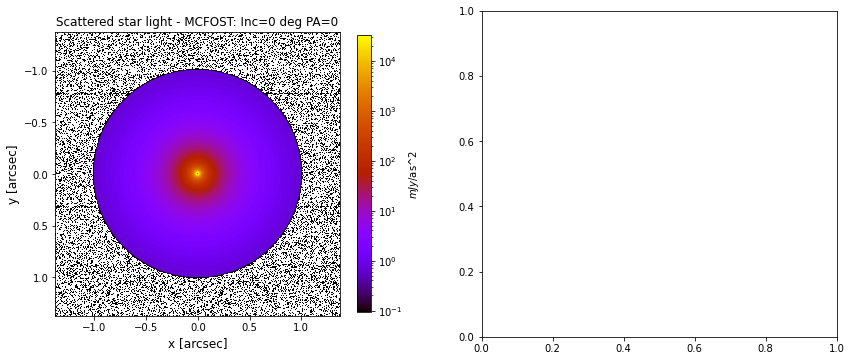

In [75]:
fig=plt.figure(figsize=(14, 6))
ax2=plt.subplot(121)
im2=ax2.imshow(sst_jy.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)],norm=LogNorm())
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]',fontsize=12)
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title('Scattered star light - MCFOST: Inc=0 deg PA=0',fontsize=12)
cb=plt.colorbar(im2,orientation='vertical',shrink=0.85)
cb.set_label("$mJy$/as^2")

ax2=plt.subplot(122)
im2=ax2.imshow(zo_file[0].data.astype(np.float64)/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)],norm=LogNorm())
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]',fontsize=12)
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title('Scattered star light - Zodipic: Inc=0 deg PA=0',fontsize=12)
cb=plt.colorbar(im2,orientation='vertical', shrink=0.85)
cb.set_label("$mJy$/as^2")
fig.subplots_adjust(hspace=0.1, wspace=0.25, top=0.9, right=0.95)
#fig.savefig('/home/ramya/OneDrive/Debris-Disk-Modelling/Zodipic/'+'zodipic_inc75_pa266_ver3.pdf', format='pdf', bbox_inches='tight')


NameError: name 'zo_file' is not defined

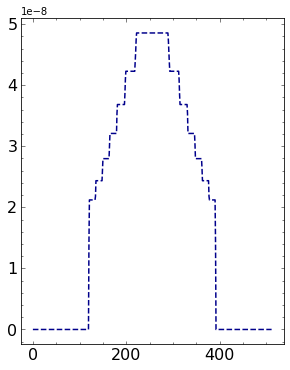

In [76]:
fig=plt.figure(figsize=(16, 6))
ax2=plt.subplot(131)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(sst_jy[:,128].astype(np.float64), color='darkblue',label='MCFOST',linestyle='dashed')
ax2.plot(zo_file[0].data[:,128].astype(np.float64),c='m',label='Zodipic',linestyle='solid')
ax2.set_ylabel('SB in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)

ax2=plt.subplot(132)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(sst_jy[:,128].astype(np.float64)[100:150], c='dodgerblue',label='MCFOST',linestyle='dashed')
ax2.plot(zo_file[0].data[:,128].astype(np.float64)[100:150],c='crimson',label='Zodipic',linestyle='solid')
ax2.set_ylabel('SB in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)

ax2=plt.subplot(133)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
ax2.plot(np.log10(sst_jy[129:256,128].astype(np.float64)), c='darkgreen',label='MCFOST',linestyle='dashed')
ax2.plot(np.log10(zo_file[0].data[129:256,128].astype(np.float64)),c='purple',label='Zodipic',linestyle='solid')
ax2.set_ylabel('log[SB] in Jy ',fontsize=16)
ax2.set_xlabel('Pixels',fontsize=16)
ax2.set_title('Scattered star light',fontsize=16)
ax2.legend(loc='upper right',fontsize=16)
fig.subplots_adjust(hspace=0.1, wspace=0.4, top=0.9, right=0.95)
#fig.savefig('/home/ramya/OneDrive/Debris-Disk-Modelling/Zodipic/'+'zodipic_inc75_pa266_ver3_crosssection.pdf', format='pdf', bbox_inches='tight')
